## Intro
Given a predefined set of stocks, our objective is to identify the optimal subset that minimizes risk while ensuring cross-sectoral diversification.

We propose two approaches:

1. Sign Entropy: This method evaluates each stock subgroup's factor exposure signs. A high sign entropy indicates balanced exposure across risk factors, suggesting greater diversification.

Calculation:
For each risk factor, calculate the proportions of positive and negative factor exposures ($p_+$ and $p_−$).
Compute the sign entropy using the formula:
$$\text{sign entropy} = - p_{+} log(p_{+}) - p_{-} log(p_{-})$$

Interpretation:
- A higher sign entropy implies more balanced exposure across risk factors.
- A sign entropy of log(2) represents perfect diversification (equal positive and negative exposures).

2. Variance: This approach directly calculates the portfolio variance for each subgroup and selects the one with the minimum variance.

While both approaches yield identical results, the sign entropy method is computationally more efficient due to reduced matrix operations.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
idx = pd.IndexSlice


In [2]:
import yahooquery as yq
from itertools import combinations

## Setting

We will begin by selecting a universe of 25 stocks. Our goal is to identify the most diversified subset of 18 stocks, adhering to the following criteria:

Sector Classification: All 25 stocks will be categorized into sectors such as Technology, Healthcare, Financial Services, etc.
Balanced Representation: The optimal 18-stock subset must include:
- 4 stocks from Technology
- 4 stocks from Financial Services
- 3 stocks from Consumer Defensive
- 3 stocks from Energy
- 1 stock from each of the remaining 4 sectors

In [3]:
from import_and_clean_historic_data import select_and_process_historical_data

data = select_and_process_historical_data(filename='HISTORIC_PRICES.csv', number_stocks=25)
print(data.head())
print(data.tail())
print('\n')
print(data.info())

                       open       high       low      close       volume
ticker date                                                             
AAPL   2006-01-04  9.655252   9.764489  9.574288   9.634690  154900900.0
       2006-01-05  9.616698   9.625694  9.477903   9.558867  112355600.0
       2006-01-06  9.669389   9.857019  9.580714   9.805613  176114400.0
       2006-01-09  9.860874   9.921276  9.733646   9.773485  168760200.0
       2006-01-10  9.799188  10.524006  9.745212  10.391637  569967300.0
                        open       high        low      close      volume
ticker date                                                              
KO     2016-12-23  40.594828  40.663104  40.331479  40.575321   6435216.0
       2016-12-27  40.536306  40.731380  40.516799  40.585074   6998769.0
       2016-12-28  40.468030  40.643596  40.370493  40.370493   8987984.0
       2016-12-29  40.360740  40.663104  40.360740  40.575321   6875301.0
       2016-12-30  40.663104  40.809409  40.3

In [4]:
data.index.unique('ticker')

Index(['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC', 'CSCO',
       'AMZN', 'V', 'PFE', 'GS', 'CVX', 'WFC', 'JNJ', 'IBM', 'QCOM', 'ORCL',
       'T', 'PG', 'SLB', 'WMT', 'KO'],
      dtype='object', name='ticker')

In [5]:
list_ticker = data.index.unique('ticker').tolist()
tickers = yq.Ticker(list_ticker)
df = pd.DataFrame(tickers.asset_profile)
df_sector = df.loc['sector', :].to_frame()
df_sector.index.name = 'ticker'
df_sector.head()

,sector
ticker,
AAPL,Technology
GOOGL,Communication Services
MSFT,Technology
BAC,Financial Services
XOM,Energy


In [6]:
df_sector.sector.unique()

array(['Technology', 'Communication Services', 'Financial Services',
       'Energy', 'Industrials', 'Consumer Cyclical', 'Healthcare',
       'Consumer Defensive'], dtype=object)

In [7]:
sector_ticker_dict = {}
num_tick_sector = {}
for i, j in df_sector.groupby('sector', group_keys=False):
    sector_ticker_dict[i] = j.index.tolist()
    num_tick_sector[i] = len(j.index.tolist())

In [8]:
sector_ticker_dict

{'Communication Services': ['GOOGL', 'T'],
 'Consumer Cyclical': ['AMZN'],
 'Consumer Defensive': ['PG', 'WMT', 'KO'],
 'Energy': ['XOM', 'CVX', 'SLB'],
 'Financial Services': ['BAC', 'C', 'JPM', 'V', 'GS', 'WFC'],
 'Healthcare': ['PFE', 'JNJ'],
 'Industrials': ['GE'],
 'Technology': ['AAPL', 'MSFT', 'INTC', 'CSCO', 'IBM', 'QCOM', 'ORCL']}

In [9]:
df = pd.DataFrame(num_tick_sector, index=['number_of_companies'])
df

,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Technology
number_of_companies,2,1,3,3,6,2,1,7


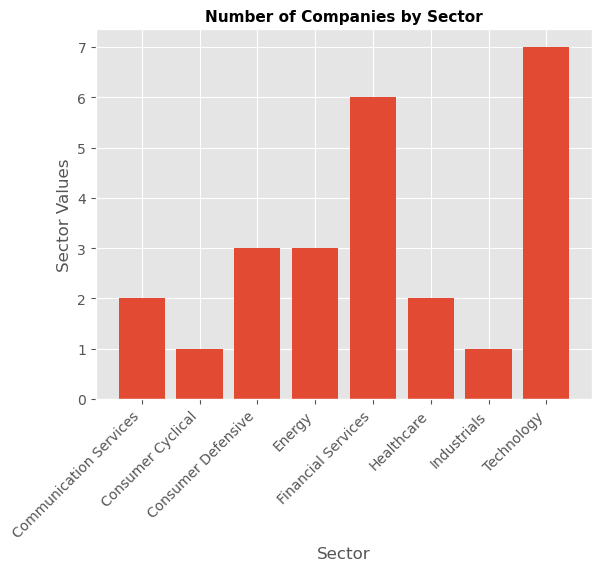

In [10]:
fig, ax = plt.subplots()

ax.bar(df.T.index, df.T['number_of_companies'])
ax.set_xlabel('Sector')
ax.set_ylabel('Sector Values')
ax.set_title('Number of Companies by Sector', fontweight='bold', fontsize=11)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')   
fig.show()            


In [11]:
sector_ticker_dict

{'Communication Services': ['GOOGL', 'T'],
 'Consumer Cyclical': ['AMZN'],
 'Consumer Defensive': ['PG', 'WMT', 'KO'],
 'Energy': ['XOM', 'CVX', 'SLB'],
 'Financial Services': ['BAC', 'C', 'JPM', 'V', 'GS', 'WFC'],
 'Healthcare': ['PFE', 'JNJ'],
 'Industrials': ['GE'],
 'Technology': ['AAPL', 'MSFT', 'INTC', 'CSCO', 'IBM', 'QCOM', 'ORCL']}

The optimal 18-stock subset must include:
- 4 stocks from Technology
- 4 stocks from Financial Services
- 3 stocks from Consumer Defensive
- 3 stocks from Energy
- 1 stock from each of the remaining sectors

In [12]:
parsed_dicts = sector_ticker_dict.copy()


In [13]:
parsed_dicts

{'Communication Services': ['GOOGL', 'T'],
 'Consumer Cyclical': ['AMZN'],
 'Consumer Defensive': ['PG', 'WMT', 'KO'],
 'Energy': ['XOM', 'CVX', 'SLB'],
 'Financial Services': ['BAC', 'C', 'JPM', 'V', 'GS', 'WFC'],
 'Healthcare': ['PFE', 'JNJ'],
 'Industrials': ['GE'],
 'Technology': ['AAPL', 'MSFT', 'INTC', 'CSCO', 'IBM', 'QCOM', 'ORCL']}

In [14]:
# build the new dataframe
parsed_dicts = sector_ticker_dict.copy()
comb = lambda x, num: [list(set(k)) for k in list(combinations(x, num))]

parsed_dicts['Technology'] = comb(parsed_dicts['Technology'], 4)
parsed_dicts['Financial Services'] = comb(parsed_dicts['Financial Services'], 4)
parsed_dicts['Consumer Defensive'] = comb(parsed_dicts['Consumer Defensive'], 3)
parsed_dicts['Energy'] = comb(parsed_dicts['Energy'], 3)




parsed_dicts

{'Communication Services': ['GOOGL', 'T'],
 'Consumer Cyclical': ['AMZN'],
 'Consumer Defensive': [['WMT', 'PG', 'KO']],
 'Energy': [['SLB', 'CVX', 'XOM']],
 'Financial Services': [['JPM', 'V', 'BAC', 'C'],
  ['JPM', 'GS', 'BAC', 'C'],
  ['JPM', 'WFC', 'BAC', 'C'],
  ['GS', 'V', 'BAC', 'C'],
  ['WFC', 'V', 'BAC', 'C'],
  ['GS', 'WFC', 'BAC', 'C'],
  ['JPM', 'GS', 'BAC', 'V'],
  ['JPM', 'WFC', 'BAC', 'V'],
  ['JPM', 'GS', 'WFC', 'BAC'],
  ['GS', 'WFC', 'BAC', 'V'],
  ['JPM', 'GS', 'V', 'C'],
  ['JPM', 'WFC', 'V', 'C'],
  ['JPM', 'GS', 'WFC', 'C'],
  ['GS', 'WFC', 'V', 'C'],
  ['JPM', 'GS', 'WFC', 'V']],
 'Healthcare': ['PFE', 'JNJ'],
 'Industrials': ['GE'],
 'Technology': [['AAPL', 'INTC', 'CSCO', 'MSFT'],
  ['AAPL', 'INTC', 'IBM', 'MSFT'],
  ['AAPL', 'INTC', 'QCOM', 'MSFT'],
  ['AAPL', 'INTC', 'ORCL', 'MSFT'],
  ['AAPL', 'CSCO', 'IBM', 'MSFT'],
  ['AAPL', 'QCOM', 'CSCO', 'MSFT'],
  ['AAPL', 'CSCO', 'ORCL', 'MSFT'],
  ['AAPL', 'QCOM', 'IBM', 'MSFT'],
  ['AAPL', 'ORCL', 'IBM', 'MSFT'],
 

### Fama-French 5-factor risk model

In [15]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2006, end=2017)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
factor_data.drop(['RF'], axis=1, inplace=True)
factor_names = factor_data.columns

In [16]:
factor_data.head()

,MARKET,SMB,HML,RMW,CMA
date,,,,,
2006-01-03,1.50,-0.15,0.16,0.18,-0.32
2006-01-04,0.46,0.31,0.03,-0.45,0.33
2006-01-05,0.03,0.23,-0.10,-0.55,0.20
2006-01-06,0.92,0.10,-0.24,-0.04,0.14
2006-01-09,0.45,0.51,-0.17,0.06,-0.03


In [17]:
factor_data.tail()

,MARKET,SMB,HML,RMW,CMA
date,,,,,
2016-12-23,0.19,0.53,-0.50,-0.36,-0.15
2016-12-27,0.27,0.23,0.14,0.17,0.04
2016-12-28,-0.87,-0.29,0.09,0.17,-0.15
2016-12-29,-0.04,0.10,-0.33,0.27,0.02
2016-12-30,-0.52,-0.06,0.20,-0.11,0.03


### Search: Grid search optimization

Find the maximum average of the exponential of sign entropy as defined in the intro duction

In [18]:
def flatten(nested_list):

    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend((flatten(item)))
        else:
            flattened.append(item)
    return flattened

In [19]:
def sign_entropy(betas):

    pos_sign_prob = (betas > 0).astype(int).sum().div(len(betas))
    neg_sign_prob = (betas < 0).astype(int).sum().div(len(betas))

    sign_entropy =  - (pos_sign_prob * np.log(pos_sign_prob) + neg_sign_prob * np.log(neg_sign_prob)).fillna(0)

    return sign_entropy

In [20]:
def plot_optimal_betas(optimal_beta_df, risk_factor_names, optimal_ticker_entropy):

    fig, ax = plt.subplots(figsize=(12, 6))
    num_tickers = len(optimal_beta_df.index)
    num_factors = len(optimal_beta_df.columns)
    bar_width = 0.04
    indices = np.arange(num_factors)


    for i, ticker in enumerate(optimal_beta_df.index):
        bar_positions = indices + i * bar_width
        ax.bar(bar_positions, optimal_beta_df.loc[ticker], width=bar_width, label=ticker)


    ax.set_ylabel('Exposure Level', fontsize=10)
    ax.set_title('Factor Exposures by Sector', fontsize=13, fontweight='bold')
                
    ax.set_xticks(indices + bar_width * (num_factors / 2) - bar_width / 2)
    ax.set_xticklabels(risk_factor_names)
    plt.grid(axis='y', color='gray', linestyle='--', alpha=.3)


    ax.legend(ncol=len(optimal_ticker_entropy), title='Ticker', fontsize=5.4)
    plt.show()




In [21]:
list_st = []
all_list = []
entropy_list = []
list_risks = []
list_dist = []
factor_names = factor_data.columns

max_entropy = 0.0
min_risk = 1.0e6

for i in parsed_dicts['Communication Services']:
    for j in parsed_dicts['Consumer Cyclical']:
        for k in parsed_dicts['Financial Services']:
            for l in parsed_dicts['Technology']:
                for m in parsed_dicts['Consumer Defensive']:
                    for n in parsed_dicts['Healthcare']:
                        for o in parsed_dicts['Industrials']:
                            for p in parsed_dicts['Energy']:
                                 
                                list_st.append([i,j, k, l, m, n, o, p])
                                ticker_list = flatten(list_st)

                                sector_data = data.loc[idx[ticker_list, :], :].close.unstack('ticker').dropna()
                                sector_ret = sector_data.pct_change().dropna().unstack()
                                sector_ret.name = 'return'
                                fama_fac = factor_data.join(sector_ret).dropna()       

                                # calculating beta exposures
                                betas = (fama_fac.groupby('ticker', group_keys=False)
                                                                .apply(lambda x: sm.OLS(endog=x['return'], exog=sm.add_constant(x[factor_names]))
                                                                .fit()
                                                                .params))
                                betas = betas.loc[fama_fac.index.unique('ticker')]
                                if 'const' in betas.columns:
                                    betas = betas.drop(columns=['const'], axis=1)  
                                
                                #print(betas)

                                # calculate sign entropy and search for maximum
                                sign_entropy_per_sector =  sign_entropy(betas)
                                exp_entropy = np.exp(sign_entropy_per_sector)
                                entropy_list.append(exp_entropy.mean())
                                if exp_entropy.mean() > max_entropy:
                                    max_entropy = exp_entropy.mean() 
                                    optimal_entropy = exp_entropy
                                    optimal_ticker_entropy = ticker_list
                                    optimal_betas_entropy = betas

                                
                                # calculate portfolio risks  and search for minimum
                                date_idx = fama_fac['return'].index.unique('date')
                                factors = factor_data.loc[date_idx, :]

                                specific_ret = fama_fac['return'].unstack(0).subtract(factors.dot(betas.T)).dropna()

                                S = 252*np.diag(np.var(specific_ret, ddof=1))
                                F = np.sqrt(252)*np.cov(factors.T, ddof=1)
                                B = betas.values
                                w = np.repeat(1/len(ticker_list), len(ticker_list))
                                portfolio_risk = np.sqrt(np.dot(np.dot(w.T, (np.dot(np.dot(B, F), B.T) + S)), w))
                                list_risks.append(portfolio_risk)


                                if portfolio_risk < min_risk:
                                    min_risk = portfolio_risk 
                                    optimal_betas_risk = betas
                                    optimal_ticker_risk = ticker_list


                                
                                
                                all_list.append(ticker_list)
                                list_st = []


### Optimal Entropy: maximum entropy

In [22]:
max_entropy

1.623372796114759

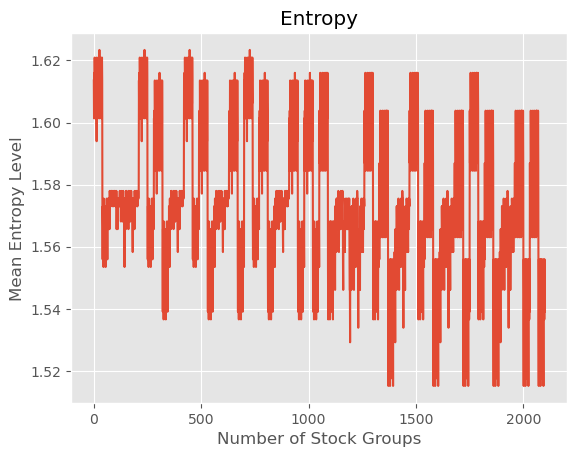

In [23]:
plt.plot(entropy_list)
plt.title('Entropy')
plt.xlabel('Number of Stock Groups')
plt.ylabel('Mean Entropy Level')
plt.show()

# Sign Entropy Approach

#### Optimal Stocks: Entropy Approach

In [24]:
print(optimal_ticker_entropy)

['GOOGL', 'AMZN', 'JPM', 'V', 'BAC', 'C', 'AAPL', 'INTC', 'IBM', 'QCOM', 'WMT', 'PG', 'KO', 'PFE', 'GE', 'SLB', 'CVX', 'XOM']


#### Optimal Beta Exposures: Entropy Approach

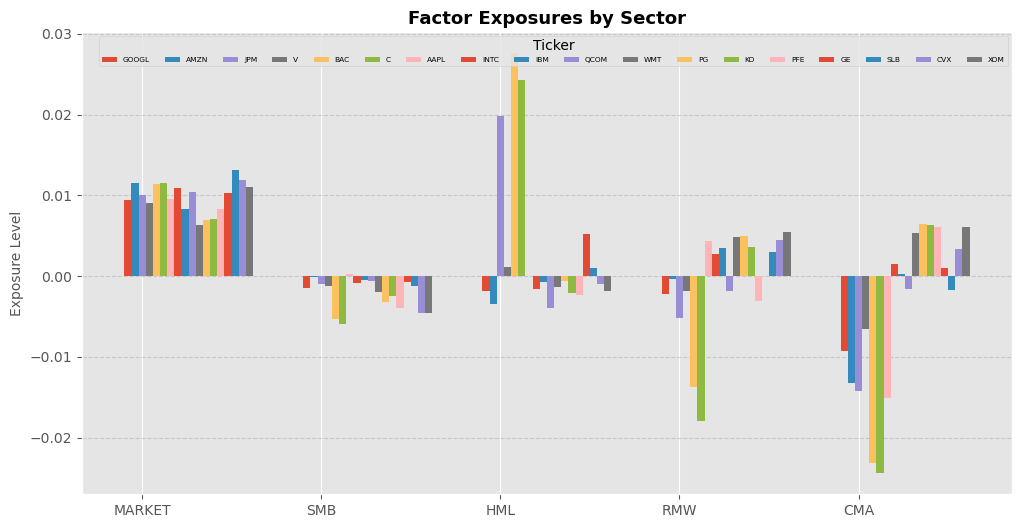

In [25]:
plot_optimal_betas(optimal_betas_entropy, factor_names, optimal_ticker_entropy)

# Variance Approach

### Optimal Risk:  minimum risk

In [26]:
min_risk

0.07083247297397677

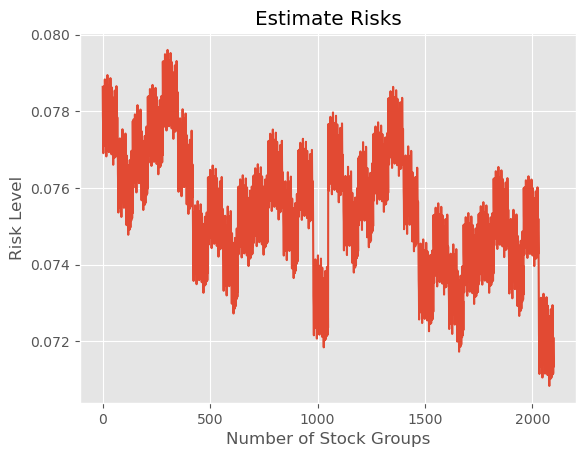

In [27]:
plt.plot(list_risks)
plt.title('Estimate Risks')
plt.xlabel('Number of Stock Groups')
plt.ylabel('Risk Level')
plt.show()

#### Optimal Stocks: Risk Approach

In [28]:
print(optimal_ticker_risk)

['T', 'AMZN', 'JPM', 'GS', 'WFC', 'V', 'IBM', 'INTC', 'ORCL', 'MSFT', 'WMT', 'PG', 'KO', 'JNJ', 'GE', 'SLB', 'CVX', 'XOM']


#### Optimal Beta Exposures: Risk Approach

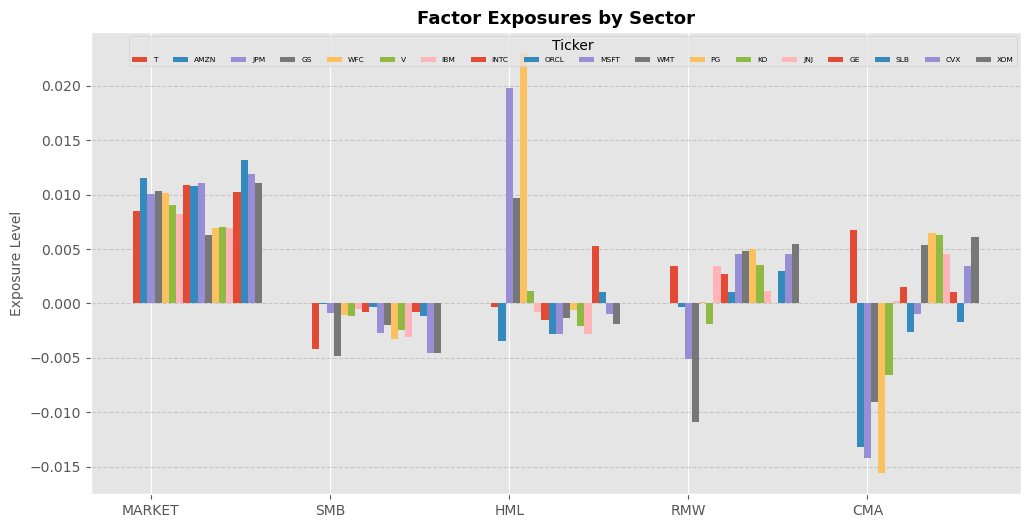

In [29]:
plot_optimal_betas(optimal_betas_risk, factor_names, optimal_ticker_risk)

#### Check similar optimal tickers capture by each method

The optimal tickers are similar for 12 tickers out of 18.

In [30]:
print(set(optimal_ticker_risk).intersection(set(optimal_ticker_entropy)))

{'WMT', 'GE', 'CVX', 'PG', 'AMZN', 'JPM', 'IBM', 'SLB', 'XOM', 'V', 'KO', 'INTC'}


#### Conclusion

To ensure optimal diversification, we focused on selecting stocks with the most balanced exposure to various risk factors. We employed two methods: sign entropy and traditional variance analysis.

While both approaches yielded qualitatively similar factor exposure profiles, the sign entropy method proved to be computationally more efficient.

Although the grid search optimization approach is less time-efficient, this is not a significant concern in a pre-trading context.

